# New Code (LASSO/Ridge/RFS/FS/OLS)


## Setup

In [1]:
!pip install pmlb

In [1]:
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import warnings
import concurrent.futures
import time
import os

def optimized_rfs(X_train, y_train, X_val, y_val, max_k, B, optimize_m=True, fit_intercept=True, fs=False):
    n, p = X_train.shape
    best_mse = float('inf')
    best_models = None

    m_range = range(1, p + 1) if optimize_m else [p // 3]
    m_range = [p] if fs else m_range

    with concurrent.futures.ProcessPoolExecutor() as executor:
        for m in m_range:
            partial_rfs = partial(perform_single_rfs, X_train=X_train, y_train=y_train, 
                                  max_k=max_k, m=m, p=p)
            
            futures = [executor.submit(partial_rfs, b) for b in range(B)]
            results = [future.result() for future in concurrent.futures.as_completed(futures)]
            
            models, coefficients = zip(*results)

            mse_values = [mean_squared_error(y_val, apply_rfs(X_train, y_train, X_val, models, k, fit_intercept))
                          for k in range(1, max_k + 1)]
            mse = min(mse_values)
            new_k = np.argmin(mse_values) + 1

            if mse < best_mse:
                best_mse = mse
                best_m = m
                best_k = new_k
                best_models = models

    return best_models, best_m, best_k

def perform_single_rfs(b, X_train, y_train, max_k, m, p):
    model = []
    residual = y_train.copy()
    coefficients = np.array([])

    for k in range(1, max_k+1):
        candidates = np.random.choice([i for i in range(p) if i not in model],
                                      size=min(m, p-len(model)), replace=False)
        inner_products = np.abs(X_train[:, candidates].T @ residual)
        best_feature = candidates[np.argmax(inner_products)]

        model.append(best_feature)
        X_new = X_train[:, model]
        coefficients = np.linalg.lstsq(X_new, y_train, rcond=None)[0]
        residual = y_train - X_new @ coefficients

    return model, coefficients

def apply_rfs(X_train, y_train, X_test, models, k, fit_intercept):
    predictions = np.zeros(len(X_test))
    for model in models:
        X_train_subset = X_train[:, model[:k]]
        X_test_subset = X_test[:, model[:k]]

        if fit_intercept:
            X_train_subset = np.column_stack([np.ones(X_train_subset.shape[0]), X_train_subset])
            X_test_subset = np.column_stack([np.ones(X_test_subset.shape[0]), X_test_subset])

        lr = np.linalg.lstsq(X_train_subset, y_train, rcond=None)[0]
        predictions += X_test_subset @ lr

    return predictions / len(models)

## Data Generation

In [2]:
import numpy as np

def generate_example1(n_train=20, n_val=20, n_test=200):
    n_total = n_train + n_val + n_test
    n_predictors = 8
    beta = np.array([3, 1.5, 0, 0, 2, 0, 0, 0])
    sigma = 3

    # Generate correlation matrix
    corr_matrix = np.zeros((n_predictors, n_predictors))
    for i in range(n_predictors):
        for j in range(n_predictors):
            corr_matrix[i, j] = 0.5**abs(i-j)

    # Generate X with the correct covariance structure
    X = np.random.multivariate_normal(np.zeros(n_predictors), corr_matrix, n_total)

    # Generate response
    y = X @ beta + np.random.normal(0, sigma, n_total)

    # Split the data
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test, n_predictors

def generate_example2(n_train=20, n_val=20, n_test=200):
    n_total = n_train + n_val + n_test
    n_predictors = 8
    beta = np.array([0.85] * 8)
    sigma = 3

    # Use the same correlation structure as in example 1
    corr_matrix = np.zeros((n_predictors, n_predictors))
    for i in range(n_predictors):
        for j in range(n_predictors):
            corr_matrix[i, j] = 0.5**abs(i-j)

    # Generate X with the correct covariance structure
    X = np.random.multivariate_normal(np.zeros(n_predictors), corr_matrix, n_total)

    # Generate response
    y = X @ beta + np.random.normal(0, sigma, n_total)

    # Split the data
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test, n_predictors

def generate_example3(n_train=100, n_val=100, n_test=400):
    n_total = n_train + n_val + n_test
    n_predictors = 40
    beta = np.concatenate([np.zeros(10), np.full(10, 2), np.zeros(10), np.full(10, 2)])
    sigma = 15

    # Generate correlation matrix with constant correlation of 0.5
    corr_matrix = 0.5 * np.ones((n_predictors, n_predictors)) + 0.5 * np.eye(n_predictors)

    # Generate X with the correct covariance structure
    X = np.random.multivariate_normal(np.zeros(n_predictors), corr_matrix, n_total)

    # Generate response
    y = X @ beta + np.random.normal(0, sigma, n_total)

    # Split the data
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test, n_predictors

def generate_example4(n_train=50, n_val=50, n_test=400):
    n_total = n_train + n_val + n_test
    n_predictors = 40
    beta = np.concatenate([np.full(15, 3), np.zeros(25)])
    sigma = 15

    # Generate Z variables
    Z1 = np.random.normal(0, 1, n_total)
    Z2 = np.random.normal(0, 1, n_total)
    Z3 = np.random.normal(0, 1, n_total)

    # Generate X
    X = np.zeros((n_total, n_predictors))
    for i in range(5):
        X[:, i] = Z1 + np.random.normal(0, 0.01, n_total)
    for i in range(5, 10):
        X[:, i] = Z2 + np.random.normal(0, 0.01, n_total)
    for i in range(10, 15):
        X[:, i] = Z3 + np.random.normal(0, 0.01, n_total)
    for i in range(15, 40):
        X[:, i] = np.random.normal(0, 0.01, n_total)

    # Generate response
    y = X @ beta + np.random.normal(0, sigma, n_total)

    # Split the data
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test, n_predictors

In [3]:
def generate_example5(n_train=50, n_val=50, n_test=300):
    n_total = n_train + n_val + n_test
    n_predictors = 100
    beta = np.concatenate([np.full(5, 5), np.zeros(95)])
    sigma = 3

    # Generate correlation matrix with constant correlation of 0.5
    corr_matrix = 0.5 * np.ones((n_predictors, n_predictors)) + 0.5 * np.eye(n_predictors)

    # Generate X with the correct covariance structure
    X = np.random.multivariate_normal(np.zeros(n_predictors), corr_matrix, n_total)

    # Generate response
    y = X @ beta + np.random.normal(0, sigma, n_total)

    # Split the data
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test, n_predictors

def generate_example6(n_train=50, n_val=50, n_test=300):
    n_total = n_train + n_val + n_test
    n_predictors = 100
    beta = np.concatenate([np.full(5, 5), np.zeros(95)])
    sigma = 3

    # Generate correlation matrix with constant correlation of 0
    corr_matrix = np.eye(n_predictors)

    # Generate X with the correct covariance structure
    X = np.random.multivariate_normal(np.zeros(n_predictors), corr_matrix, n_total)

    # Generate response
    y = X @ beta + np.random.normal(0, sigma, n_total)

    # Split the data
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test, n_predictors

## Simulation

### Setup

In [4]:
def run_single_simulation(sim, generate_example_func, B1=500, B2=500):
    timings = {}
    
    # Generate data
    start_time = time.time()
    X_train, y_train, X_val, y_val, X_test, y_test, p = generate_example_func(seed=123+sim)
    timings['data_generation'] = time.time() - start_time

    start_time = time.time()
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    timings['data_scaling'] = time.time() - start_time

    # Function to perform cross-validation for a single alpha
    def cv_score(alpha, model_class, X, y):
        model = model_class(alpha=alpha)
        return cross_val_score(model, X, y, cv=5).mean()

    # Function to perform cross-validation for Elastic Net
    def cv_score_elastic(params, X, y):
        alpha, l1_ratio = params
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)
        return cross_val_score(model, X, y, cv=5).mean()

    # Parallel hyperparameter tuning
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Lasso
        start_time = time.time()
        alphas = np.logspace(-4, 1, 50)
        lasso_scores = list(executor.map(partial(cv_score, model_class=Lasso, X=X_train, y=y_train), alphas))
        best_alpha_lasso = alphas[np.argmax(lasso_scores)]
        lasso = Lasso(alpha=best_alpha_lasso, fit_intercept=True).fit(X_train, y_train)
        mse_lasso = mean_squared_error(y_test, lasso.predict(X_test))
        timings['lasso'] = time.time() - start_time

        # Elastic Net
        start_time = time.time()
        l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
        param_grid = [(alpha, l1_ratio) for alpha in alphas for l1_ratio in l1_ratios]
        elastic_scores = list(executor.map(partial(cv_score_elastic, X=X_train, y=y_train), param_grid))
        best_params = param_grid[np.argmax(elastic_scores)]
        best_alpha_elastic, best_ratio = best_params
        elastic = ElasticNet(alpha=best_alpha_elastic, l1_ratio=best_ratio, fit_intercept=True).fit(X_train, y_train)
        mse_elastic = mean_squared_error(y_test, elastic.predict(X_test))
        timings['elastic_net'] = time.time() - start_time

        # Ridge
        start_time = time.time()
        ridge_scores = list(executor.map(partial(cv_score, model_class=Ridge, X=X_train, y=y_train), alphas))
        best_alpha_ridge = alphas[np.argmax(ridge_scores)]
        ridge = Ridge(alpha=best_alpha_ridge, fit_intercept=True).fit(X_train, y_train)
        mse_ridge = mean_squared_error(y_test, ridge.predict(X_test))
        timings['ridge'] = time.time() - start_time

    # RFS without optimized m
    start_time = time.time()
    rfs_models_unopt, _, best_k_unopt = optimized_rfs(X_train, y_train, X_val, y_val, p, B1, optimize_m=False)
    rfs_pred_unopt = apply_rfs(X_train, y_train, X_test, rfs_models_unopt, best_k_unopt, fit_intercept=True)
    mse_rfs_unopt = mean_squared_error(y_test, rfs_pred_unopt)
    timings['rfs_unoptimized'] = time.time() - start_time
    
    # RFS with optimized m
    start_time = time.time()
    rfs_models_opt, best_m_opt, best_k_opt = optimized_rfs(X_train, y_train, X_val, y_val, p, B2, optimize_m=True)
    rfs_pred_opt = apply_rfs(X_train, y_train, X_test, rfs_models_opt, best_k_opt, fit_intercept=True)
    mse_rfs_opt = mean_squared_error(y_test, rfs_pred_opt)
    timings['rfs_optimized'] = time.time() - start_time

    # FS (RFS with B=1)
    start_time = time.time()
    fs_models, _, best_k_fs = optimized_rfs(X_train, y_train, X_val, y_val, p, B=1, fs=True)
    fs_pred = apply_rfs(X_train, y_train, X_test, fs_models, best_k_fs, fit_intercept=True)
    mse_fs = mean_squared_error(y_test, fs_pred)
    timings['forward_stepwise'] = time.time() - start_time

    # OLS
    start_time = time.time()
    ols = LinearRegression(fit_intercept=True).fit(X_train, y_train)
    mse_ols = mean_squared_error(y_test, ols.predict(X_test))
    timings['ols'] = time.time() - start_time

    # Write timings to file
    with open(f'simulation_timings_{sim}.txt', 'w') as f:
        for method, time_taken in timings.items():
            f.write(f"{method}: {time_taken:.4f} seconds\n")

    return (mse_lasso, mse_elastic, mse_ridge, mse_rfs_unopt, mse_rfs_opt, mse_fs, mse_ols, 
            best_m_opt, best_k_unopt, best_k_opt, best_k_fs, timings)

def run_simulation(generate_example_name, example_name, n_simulations, B1=500, B2=500):
    generate_example_func = globals()[generate_example_name]
    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_to_sim = {executor.submit(run_single_simulation, sim, generate_example_func, B1, B2): sim 
                         for sim in range(n_simulations)}
        results = []
        for future in tqdm(concurrent.futures.as_completed(future_to_sim), total=n_simulations, desc=f"Running {example_name}"):
            results.append(future.result())

    # Unpack results
    mse_lasso, mse_elastic, mse_ridge, mse_rfs_unopt, mse_rfs_opt, mse_fs, mse_ols, best_ms, best_ks_unopt, best_ks_opt, best_ks_fs, timings = zip(*results)

    # Write average timings to file
    avg_timings = {method: sum(t[method] for t in timings) / len(timings) for method in timings[0]}
    with open(f'average_timings_{example_name}.txt', 'w') as f:
        for method, avg_time in avg_timings.items():
            f.write(f"Average {method}: {avg_time:.4f} seconds\n")

    # Convert to numpy arrays
    return (np.array(mse_lasso), np.array(mse_elastic), np.array(mse_ridge), 
            np.array(mse_rfs_unopt), np.array(mse_rfs_opt), np.array(mse_fs), 
            np.array(mse_ols), np.array(best_ms), np.array(best_ks_unopt), 
            np.array(best_ks_opt), np.array(best_ks_fs))

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_results(results):
    # Prepare data for plotting
    plot_data = []
    methods = ['Lasso', 'Elastic Net', 'Ridge', 'RFS Unopt', 'RFS Opt', 'FS', 'OLS']

    for example_name, data in results.items():
        for method, mse_values in zip(methods, data[:6]):  # Only the first 6 elements are MSE values
            for mse in mse_values:
                plot_data.append({
                    'Example': example_name,
                    'Method': method,
                    'MSE': mse
                })

    df = pd.DataFrame(plot_data)
    df_chopped = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for example in df.Example.unique():
        for method in df.Method.unique():
            filter = np.where((df['Example']==example) & (df['Method']==method))
            df_chopped.loc[filter]['MSE'] = df_chopped.loc[filter]['MSE'].clip(df_chopped.loc[filter]['MSE'].quantile(0.1), df_chopped.loc[filter]['MSE'].quantile(0.9))

    # Set up the plot
    fig, axes = plt.subplots(2,3, figsize=(30, 20))
    plt.rcParams.update({'font.size': 24})
    axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate
    sns.set_style("whitegrid")
    sns.set_palette("Set3")

    for i, (example_name, ax) in enumerate(zip(results.keys(), axes)):
        # Filter data for this example
        example_data = df_chopped[df_chopped['Example'] == example_name]

        # Create the boxplot for this example
        sns.boxplot(x='Method', y='MSE', data=example_data, ax=ax, showfliers=False)

        # Customize the subplot
        ax.set_title(f'{example_name}', fontsize=24)
        ax.set_xlabel('Method', fontsize=24)
        ax.set_ylabel('Mean Squared Error', fontsize=24)
        # ax.set_yscale('log')
        ax.tick_params(axis='x', rotation=45)

        # Only show y-axis label for left subplots
        if i % 3 != 0:
            ax.set_ylabel('')

        # Only show x-axis label for bottom subplots
        if i < 3:
            ax.set_xlabel('')

    # Add a main title
    fig.suptitle('Comparison of Regression Methods across Examples', fontsize=35)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust top spacing for main title
    plt.savefig('simulations.png')
    plt.show()

### Results

In [ ]:
import random
import warnings

warnings.filterwarnings('ignore')

random.seed(123)

# Simulation parameters
n_simulations = 50

# Run simulations for all examples
examples = [
    ("generate_example1", "Example 1"),
    (generate_example2, "Example 2"),
    (generate_example3, "Example 3"),
    (generate_example4, "Example 4"),
    (generate_example5, "Example 5"),
    (generate_example6, "Example 6")
]

results = {}

for i in range(len(examples)):
    example_name = examples[i][1]
    generate_func = examples[i][0]
    results[example_name] = run_simulation(generate_func, example_name, n_simulations)
#     if (i < 2):
#         results[example_name] = run_simulation(generate_func, example_name, n_simulations)
#     else:
#         results[example_name] = run_simulation(generate_func, example_name, n_simulations, B2=50)


Running Example 1:   0%|                                                                        | 0/50 [00:00<?, ?it/s]

In [25]:
# Print results
for example_name, (mse_lasso, mse_elastic, mse_ridge, mse_rfs_unopt, mse_rfs_opt, mse_fs, mse_ols, best_ms, best_ks_unopt, best_ks_opt) in results.items():
    print(f"\nResults for {example_name}:")
    print(f"Median MSE Lasso: {np.median(mse_lasso):.3f} (±{np.std(mse_lasso, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median MSE Elastic Net: {np.median(mse_elastic):.3f} (±{np.std(mse_elastic, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median MSE Ridge: {np.median(mse_ridge):.3f} (±{np.std(mse_ridge, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median MSE RFS Unoptimized: {np.median(mse_rfs_unopt):.3f} (±{np.std(mse_rfs_unopt, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median MSE RFS Optimized: {np.median(mse_rfs_opt):.3f} (±{np.std(mse_rfs_opt, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median MSE FS: {np.median(mse_fs):.3f} (±{np.std(mse_fs, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median MSE OLS: {np.median(mse_ols):.3f} (±{np.std(mse_ols, ddof=1)/np.sqrt(n_simulations):.3f})")
    print(f"Median best m: {np.median(best_ms):.2f}")
    print(f"Median best k unoptimized: {np.median(best_ks_unopt):.2f}")
    print(f"Median best k optimized: {np.median(best_ks_opt):.2f}")
    print(f"Median best k FS: {np.median(best_ks_fs):.2f}")


Results for Example 1:
Median MSE Lasso: 15.157 (±0.794)
Median MSE Elastic Net: 15.157 (±0.592)
Median MSE Ridge: 13.513 (±0.398)
Median MSE RFS Unoptimized: 13.561 (±0.792)
Median MSE RFS Optimized: 14.887 (±0.995)
Median MSE FS: 16.446 (±0.953)
Median MSE OLS: 15.962 (±0.628)
Median best m: 4.00
Median best k unoptimized: 2.00
Median best k optimized: 2.00

Results for Example 2:
Median MSE Lasso: 14.621 (±0.749)
Median MSE Elastic Net: 13.253 (±0.750)
Median MSE Ridge: 11.806 (±0.666)
Median MSE RFS Unoptimized: 12.112 (±0.580)
Median MSE RFS Optimized: 12.028 (±0.488)
Median MSE FS: 16.784 (±0.747)
Median MSE OLS: 15.985 (±1.038)
Median best m: 1.00
Median best k unoptimized: 3.00
Median best k optimized: 3.00

Results for Example 3:
Median MSE Lasso: 277.883 (±2.909)
Median MSE Elastic Net: 256.817 (±2.878)
Median MSE Ridge: 303.327 (±3.511)
Median MSE RFS Unoptimized: 282.917 (±3.865)
Median MSE RFS Optimized: 260.228 (±3.425)
Median MSE FS: 327.732 (±4.519)
Median MSE OLS: 373

In [27]:
mse_data = []
methods = ['Lasso', 'Elastic Net', 'Ridge', 'RFS Unopt', 'RFS Opt', 'FS', 'OLS']

for example_name, data in results.items():
    for method, mse_values in zip(methods, data[:7]):  # Only the first 7 elements are MSE values
        for mse in mse_values:
            mse_data.append({
                'Example': example_name,
                'Method': method,
                'MSE': mse
            })
        

df = pd.DataFrame(mse_data)
df.to_csv('simulations_mse.csv', index=False)

best_ms = []

for example_name, data in results.items():
    for m in data[7]:
        best_ms.append({
                'Example': example_name,
                'Best m': m
            })
        
df_m = pd.DataFrame(best_ms)
df_m.to_csv('best_ms.csv', index=False)

best_ks = []

for example_name, data in results.items():
    for method, k_values in zip(methods[3:6], data[8:]): 
        for k in k_values:
            best_ks.append({
                'Example': example_name,
                'Method': method,
                'Best k': k
            })
        

df_k = pd.DataFrame(best_ks)
df_k.to_csv('best_ks.csv', index=False)

In [7]:
recovered_data = pd.read_csv('simulations_mse.csv')

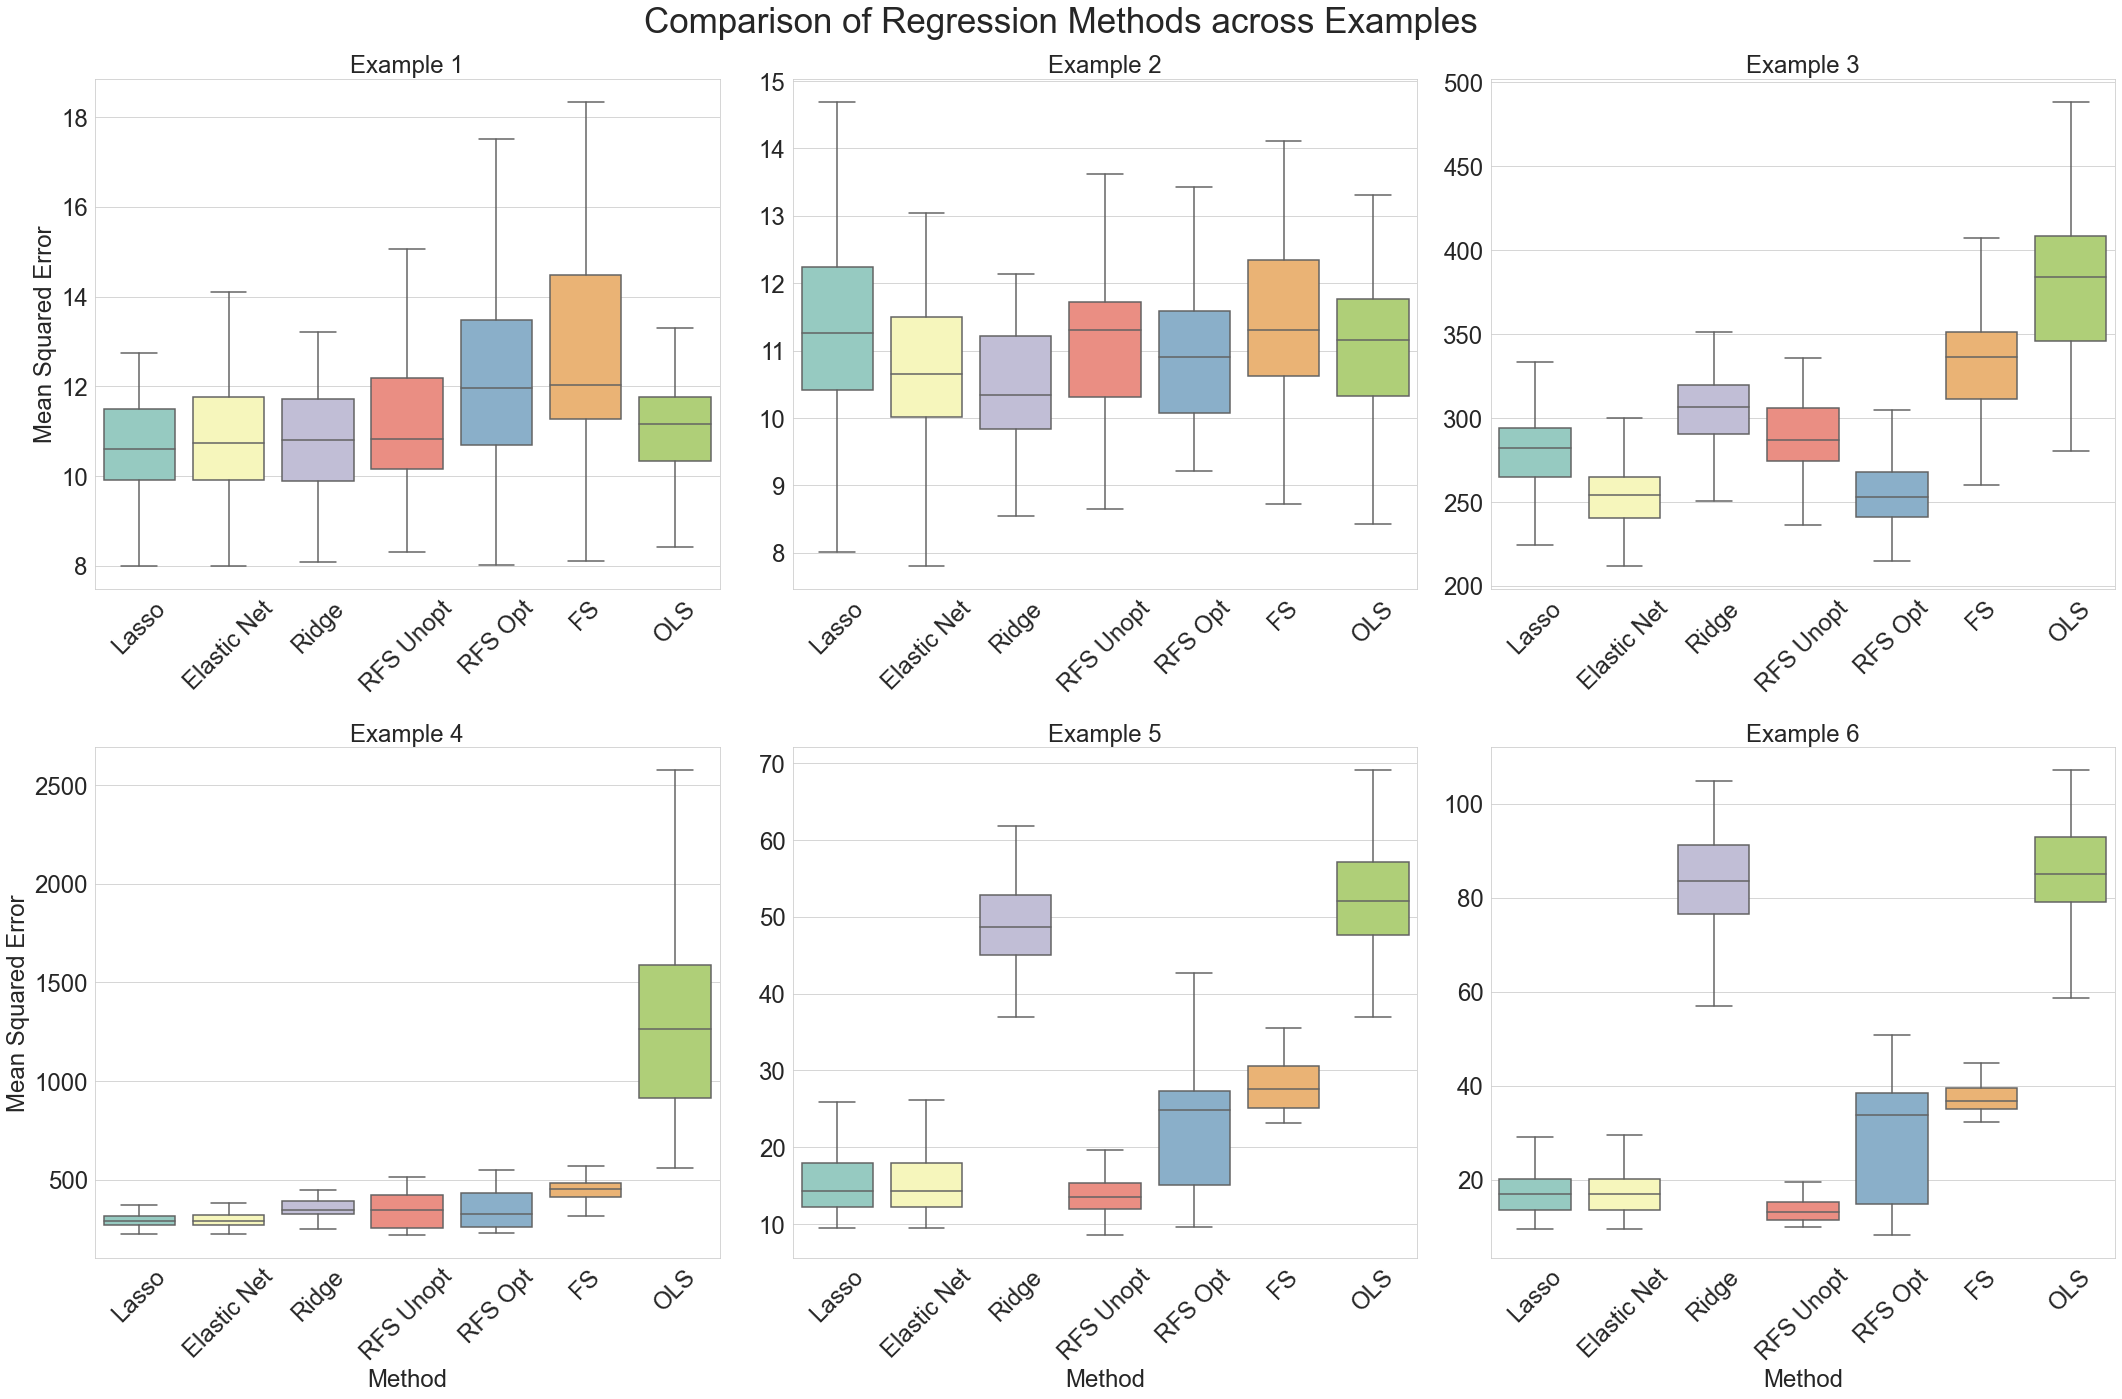

In [11]:
df_chopped = recovered_data.copy()  # Create a copy to avoid modifying the original DataFrame
for example in recovered_data.Example.unique():
    for method in recovered_data.Method.unique():
        filter = np.where((recovered_data['Example']==example) & (recovered_data['Method']==method))
        df_chopped.loc[filter]['MSE'] = df_chopped.loc[filter]['MSE'].clip(df_chopped.loc[filter]['MSE'].quantile(0.1), df_chopped.loc[filter]['MSE'].quantile(0.9))

# Set up the plot
fig, axes = plt.subplots(2,3, figsize=(30, 20))
plt.rcParams.update({'font.size': 24})
axes = axes.flatten()  # Flatten the 2x2 array to make it easier to iterate
sns.set_style("whitegrid")
sns.set_palette("Set3")

for i, (example_name, ax) in enumerate(zip(recovered_data.Example.unique(), axes)):
    # Filter data for this example
    example_data = df_chopped[df_chopped['Example'] == example_name]

    # Create the boxplot for this example
    sns.boxplot(x='Method', y='MSE', data=example_data, ax=ax, showfliers=False)

    # Customize the subplot
    ax.set_title(f'{example_name}', fontsize=24)
    ax.set_xlabel('Method', fontsize=24)
    ax.set_ylabel('Mean Squared Error', fontsize=24)
    # ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=45)

    # Only show y-axis label for left subplots
    if i % 3 != 0:
        ax.set_ylabel('')

    # Only show x-axis label for bottom subplots
    if i < 3:
        ax.set_xlabel('')

# Add a main title
fig.suptitle('Comparison of Regression Methods across Examples', fontsize=35)

# Adjust layout and show plot
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # Adjust top spacing for main title
plt.savefig('simulations_edited.png')
plt.show()

## Real Data

### Setup

In [ ]:
labels = ['Auto Pricing', 'Satellite Image', 'Bodyfat']

In [ ]:
from pmlb import fetch_data

data = {}

# Returns a pandas DataFrame
data['Auto Pricing'] = fetch_data('207_autoPrice') # 159 x 15

data['Satellite Image'] = fetch_data('294_satellite_image') # 6435 x 35

data['Political'] = fetch_data('201_pol') # 15000 x 20

data['Bodyfat'] = fetch_data('560_bodyfat') # 252 x 15

In [ ]:
# Separate features and target
Xs = {}
ys = {}

for label in labels:
    Xs[label] = data[label].drop('target', axis=1).values
    ys[label] = data[label]['target'].values

In [ ]:
import random
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings

def run_regression_comparison(X, y, n_simulations=50, random_seed=123):
    warnings.filterwarnings('ignore')
    random.seed(random_seed)
    np.random.seed(random_seed)

    n_features = X.shape[1]
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # Arrays to store results
    results = {
        'mse_lasso': np.zeros(n_simulations),
        'mse_elastic': np.zeros(n_simulations),
        'mse_ridge': np.zeros(n_simulations),
        'mse_rfs_unopt': np.zeros(n_simulations),
        'mse_rfs_opt': np.zeros(n_simulations),
        'mse_ols': np.zeros(n_simulations),
        'best_ms': np.zeros(n_simulations),
        'best_ks_unopt': np.zeros(n_simulations),
        'best_ks_opt': np.zeros(n_simulations),
        'mse_fs' : np.zeros(n_simulations),
        'best_ks_fs': np.zeros(n_simulations)
    }

    # Run simulations
    for sim in tqdm(range(n_simulations)):
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X_std, y, test_size=0.7, random_state=sim)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=sim)

        # Lasso
        lasso = Lasso(fit_intercept=True)
        alphas = np.logspace(-4, 1, 50)
        scores = [cross_val_score(Lasso(alpha=alpha), X_train, y_train, cv=5).mean()
                  for alpha in alphas]
        best_alpha = alphas[np.argmax(scores)]
        lasso.set_params(alpha=best_alpha)
        lasso.fit(X_train, y_train)
        results['mse_lasso'][sim] = mean_squared_error(y_test, lasso.predict(X_test))

        # Elastic Net
        elastic = ElasticNet(fit_intercept=True)
        l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
        scores = [cross_val_score(ElasticNet(alpha=best_alpha, l1_ratio=ratio),
                                  X_train, y_train, cv=5).mean()
                  for ratio in l1_ratios]
        best_ratio = l1_ratios[np.argmax(scores)]
        elastic.set_params(alpha=best_alpha, l1_ratio=best_ratio)
        elastic.fit(X_train, y_train)
        results['mse_elastic'][sim] = mean_squared_error(y_test, elastic.predict(X_test))

        # Ridge
        ridge = Ridge(fit_intercept=True)
        alphas = np.logspace(-4, 1, 50)
        scores = [cross_val_score(Ridge(alpha=alpha), X_train, y_train, cv=5).mean()
                  for alpha in alphas]
        best_alpha = alphas[np.argmax(scores)]
        ridge.set_params(alpha=best_alpha)
        ridge.fit(X_train, y_train)
        results['mse_ridge'][sim] = mean_squared_error(y_test, ridge.predict(X_test))

        # RFS without optimized m
        rfs_models_unopt, best_m_unopt, best_k_unopt = optimized_rfs(X_train, y_train, X_val, y_val, n_features, B=500, optimize_m=False, fit_intercept=True)
        results['best_ks_unopt'][sim] = best_k_unopt
        rfs_pred_unopt = apply_rfs(X_train, y_train, X_test, rfs_models_unopt, best_k_unopt, fit_intercept=True)
        results['mse_rfs_unopt'][sim] = mean_squared_error(y_test, rfs_pred_unopt)

        # RFS wih optimized m
        rfs_models_opt, best_m_opt, best_k_opt = optimized_rfs(X_train, y_train, X_val, y_val, n_features, B=500, optimize_m=True, fit_intercept=True)
        results['best_ms'][sim] = best_m_opt
        results['best_ks_opt'][sim] = best_k_opt
        rfs_pred_opt = apply_rfs(X_train, y_train, X_test, rfs_models_opt, best_k_opt, fit_intercept=True)
        results['mse_rfs_opt'][sim] = mean_squared_error(y_test, rfs_pred_opt)

        # FS (RFS with B=1)
        fs_models, _, best_k_fs = optimized_rfs(X_train, y_train, X_val, y_val, n_features, B=1, fs=True)
        fs_pred = apply_rfs(X_train, y_train, X_test, fs_models, best_k_fs, fit_intercept=True)
        results['mse_fs'][sim] = mean_squared_error(y_test, fs_pred)
        results['best_ks_fs'][sim] = best_k_fs

        # OLS
        ols = LinearRegression(fit_intercept=True)
        ols.fit(X_train, y_train)
        results['mse_ols'][sim] = mean_squared_error(y_test, ols.predict(X_test))

    return results

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_regression_results(results, title):
    data = []
    for method, mse in results.items():
        if method.startswith('mse_'):
            data.extend([(method[4:].capitalize(), val) for val in mse])

    df = pd.DataFrame(data, columns=['Method', 'MSE'])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Method', y='MSE', data=df)
    plt.title(title)
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=45)
    plt.tight_layout()

### Results

In [ ]:
# Run on data
results = {}

for label in labels:
    results[label] = run_regression_comparison(Xs[label], ys[label], n_simulations=50, random_seed=123)

In [ ]:
# Plot data
num_datasets = len(Xs)
fig, axes = plt.subplots(num_datasets, 1, figsize=(12, 6*num_datasets), sharex=True)

for label, result in results.items():

    data = []
    for method, mse in result.items():
        if method.startswith('mse_'):
            data.extend([(method[4:].capitalize(), val) for val in mse])

    df = pd.DataFrame(data, columns=['Method', 'MSE'])

    sns.boxplot(x='Method', y='MSE', data=df, ax=axes[i])
    axes[i].set_title(f'Dataset {i+1}')
    axes[i].set_ylabel('Mean Squared Error')

plt.xlabel('Method')
plt.tight_layout()
plt.show()

In [ ]:
for method, mse in results.items():
    if method.startswith('mse_'):
        print(f"Median MSE for {method}: {np.median(mse):.3f}")

In [ ]:
# Print results
print("Median MSE (standard error):")
print(f"Lasso: {np.median(mse_lasso):.3f} ({np.std(mse_lasso)/np.sqrt(n_simulations):.3f})")
print(f"Elastic Net: {np.median(mse_elastic):.3f} ({np.std(mse_elastic)/np.sqrt(n_simulations):.3f})")
print(f"Ridge: {np.median(mse_ridge):.3f} ({np.std(mse_ridge)/np.sqrt(n_simulations):.3f})")
print(f"RFS: {np.median(mse_rfs):.3f} ({np.std(mse_rfs)/np.sqrt(n_simulations):.3f})")
print(f"RFS median best m: {np.median(best_ms):.3f} ({np.std(best_ms)/np.sqrt(n_simulations):.3f})")
print(f"RFS median best k: {np.median(best_ks):.3f} ({np.std(best_ks)/np.sqrt(n_simulations):.3f})")
print(f"OLS: {np.median(mse_ols):.3f} ({np.std(mse_ols)/np.sqrt(n_simulations):.3f})")

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to trim the top and bottom 10% of data for each method
def trim_data(group):
    return group[(group['MSE'] >= group['MSE'].quantile(0.1)) & 
                 (group['MSE'] <= group['MSE'].quantile(0.9))]

# Function to create a box plot for a specific dataset
def create_boxplot(ax, trimmed_data, dataset, title):
    dataset_data = trimmed_data[trimmed_data['Dataset'] == dataset]
    sns.boxplot(x='Method', y='MSE', data=dataset_data, ax=ax)
    ax.set_title(f'{title} - Mean Squared Error (MSE) by Method', fontsize=16)
    ax.set_xlabel('Method', fontsize=12)
    ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12)
#     ax.set_yscale('log')  # Use log scale for y-axis due to large range of values
#     ax.tick_params(axis='x', rotation=45, ha='right')

    # Add sample size annotations
    for i, method in enumerate(dataset_data['Method'].unique()):
        sample_size = len(dataset_data[dataset_data['Method'] == method])
        ax.text(i, ax.get_ylim()[1], f'n={sample_size}', ha='center', va='bottom', fontsize=8)
# # Print summary statistics
# print(trimmed_data.groupby(['Dataset', 'Method'])['MSE'].agg(['mean', 'median', 'std', 'min', 'max']))

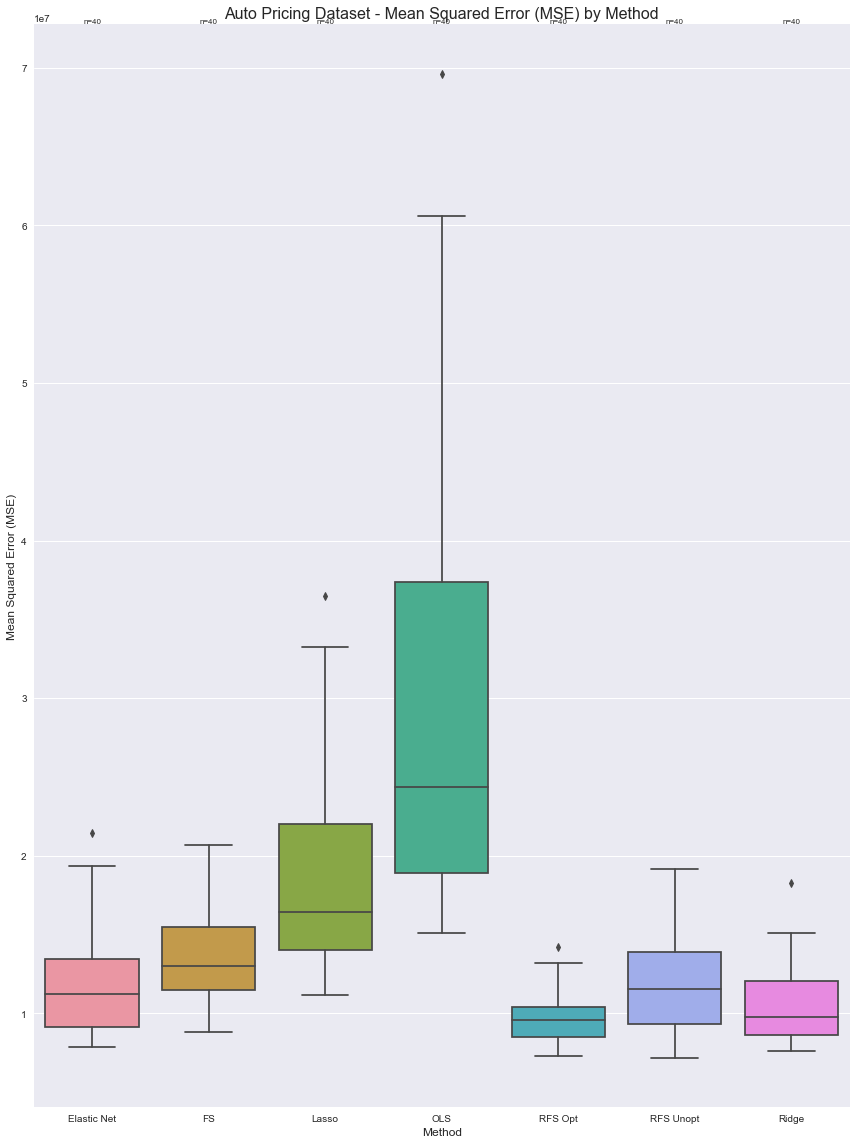

In [5]:
# Read the CSV data
data = pd.read_csv('real_data_mse.csv')

# Trim the data
trimmed_data = data.groupby(['Dataset', 'Method']).apply(trim_data).reset_index(drop=True)

# Set up the plot style
plt.style.use('seaborn')
fig, ax1 = plt.subplots(1, 1, figsize=(12, 16))

# Create box plot for Auto Pricing dataset
create_boxplot(ax1, trimmed_data, 'Auto Pricing', 'Auto Pricing Dataset')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

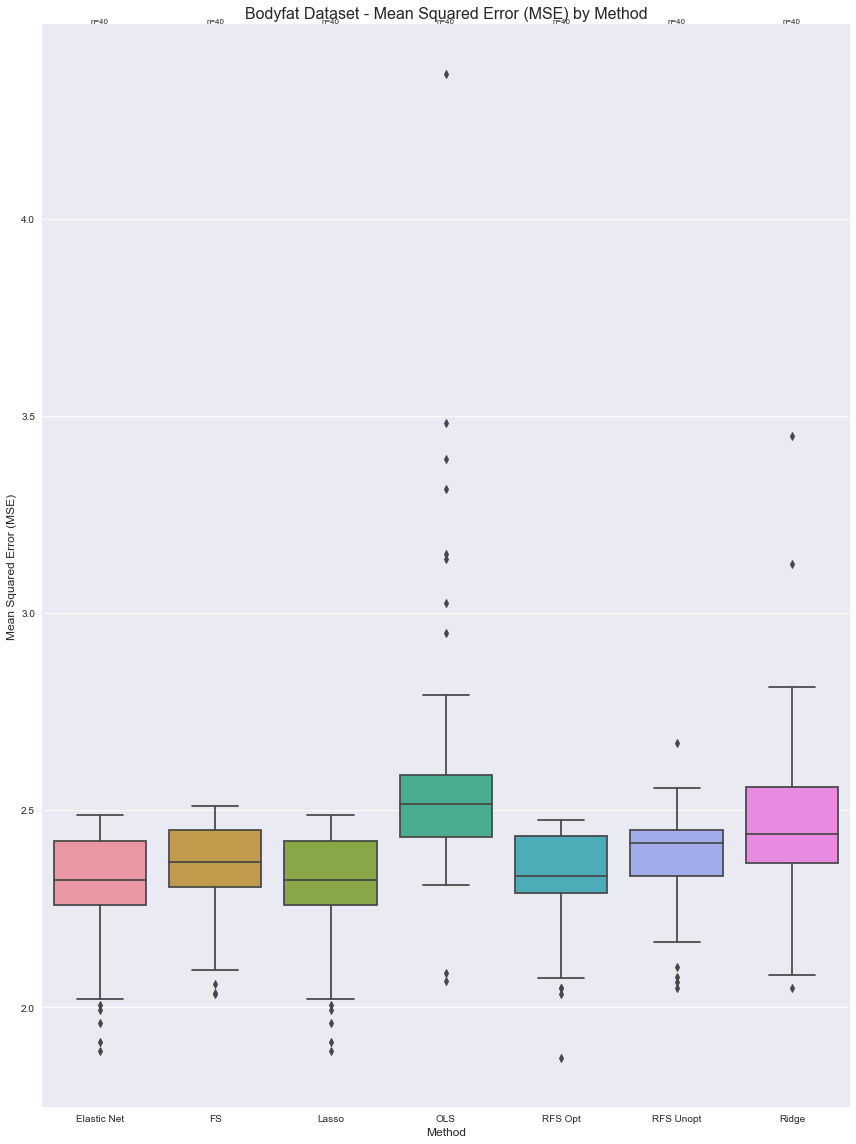

In [6]:
# Set up the plot style
plt.style.use('seaborn')
fig, ax2 = plt.subplots(1, 1, figsize=(12, 16))

# Create box plot for Bodyfat dataset
create_boxplot(ax2, trimmed_data, 'Bodyfat', 'Bodyfat Dataset')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

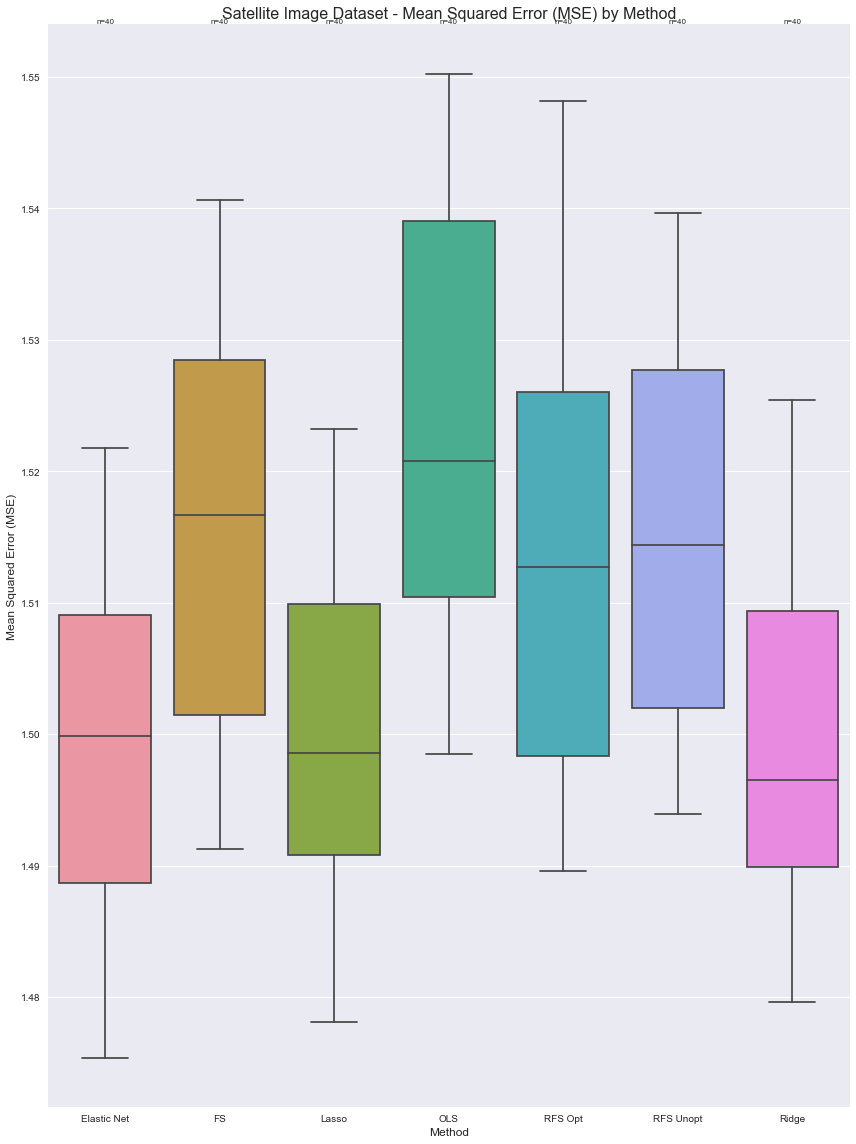

In [12]:
# Read the CSV data
data2 = pd.read_csv('real_data_mse_sat.csv')

# Trim the data
trimmed_data2 = data2.groupby(['Dataset', 'Method']).apply(trim_data).reset_index(drop=True)

# Set up the plot style
plt.style.use('seaborn')
fig, ax1 = plt.subplots(1, 1, figsize=(12, 16))

# Create box plot for Auto Pricing dataset
create_boxplot(ax1, trimmed_data2, 'Satellite Image', 'Satellite Image Dataset')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Old Code

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# Modified Randomized Forward Selection algorithm using inner products
def randomized_forward_selection(X, y, max_k, m, B):
    n, p = X.shape
    models = [[] for _ in range(B)]
    residuals = [y.copy() for _ in range(B)]

    for k in range(max_k):
        for b in range(B):
            # Randomly choose m candidate features
            candidates = np.random.choice([i for i in range(p) if i not in models[b]], size=min(m, p-len(models[b])), replace=False)
            # Calculate inner products between candidates and residual
            inner_products = np.abs([np.dot(X[:, j], residuals[b]) for j in candidates])
            best_feature = candidates[np.argmax(inner_products)]

            models[b].append(best_feature)
            X_subset = X[:, models[b]]
            model = LinearRegression().fit(X_subset, y)
            residuals[b] = y - model.predict(X_subset)  # Update residual

    return models

# Apply RFS for a specific k
def apply_rfs(X_train, y_train, X_test, models, k):
    predictions = np.zeros(len(X_test))
    for model in models:
        X_train_subset = X_train[:, model[:k]]
        lr = LinearRegression().fit(X_train_subset, y_train)
        X_test_subset = X_test[:, model[:k]]
        predictions += lr.predict(X_test_subset)
    return predictions / len(models)  # Average predictions across all models

def estimate_noise_variance(X, y):
    n, p = X.shape
    if n > p:
        model = LinearRegression().fit(X, y)
        residuals = y - model.predict(X)
        return np.mean(residuals**2) * n / (n - p)
    else:
        return np.var(y)

# Generate synthetic data (same as before)
np.random.seed(42)
n, p = 110, 100
X = np.random.randn(n, p)
X[:, 1] = 0.95 * X[:, 0] + 0.3 * np.random.randn(n)
X[:, 3] = 0.95 * X[:, 1] + 0.4 * np.random.randn(n)
X[:, 5] = 0.95 * X[:, 2] + 0.95 * X[:, 3] + 0.1 * np.random.randn(n)
true_coef = np.zeros(p)
true_coef[:6] = [1.5, -0.08, 1.1, -0.5, 0.07, -0.3]
y = X @ true_coef + np.random.normal(0, 1, n)

# Split data, standardize features, and estimate noise variance (same as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
noise_variance = estimate_noise_variance(X_train_scaled, y_train)

# Parameters
k_values = range(1, p+1)
m_values = [int(p / 3)]

best_m = None
best_criterion = float('inf')
best_k = None
all_criteria = {}

# Find best m and k for RFS
for m in tqdm(m_values, desc="m values"):
    rfs_models = randomized_forward_selection(X_train_scaled, y_train, p, m, B=100)
    criteria = []
    for k in k_values:
        train_predictions = apply_rfs(X_train_scaled, y_train, X_train_scaled, rfs_models, k)
        train_error = mean_squared_error(y_train, train_predictions)
        criterion = train_error + 2 * noise_variance * k / len(X_train)
        criteria.append(criterion)

    all_criteria[m] = criteria
    min_criterion = min(criteria)
    if min_criterion < best_criterion:
        best_criterion = min_criterion
        best_m = m
        best_k = k_values[np.argmin(criteria)]

print(f"Best m for RFS: {best_m}")
print(f"Best k for RFS: {best_k}")

# Train final RFS model with best parameters
final_models = randomized_forward_selection(X_train_scaled, y_train, p, best_m, B=1000)
final_predictions = apply_rfs(X_train_scaled, y_train, X_test_scaled, final_models, best_k)
final_mse = mean_squared_error(y_test, final_predictions)

print(f"RFS Final Test MSE: {final_mse}")

# Find best k for FS (m = p)
fs_models = randomized_forward_selection(X_train_scaled, y_train, p, p, B=1)
fs_criteria = []
for k in k_values:
    train_predictions = apply_rfs(X_train_scaled, y_train, X_train_scaled, fs_models, k)
    train_error = mean_squared_error(y_train, train_predictions)
    criterion = train_error + 2 * noise_variance * k / len(X_train)
    fs_criteria.append(criterion)

best_k_fs = k_values[np.argmin(fs_criteria)]
print(f"Best k for FS: {best_k_fs}")

# Train FS model with best k
fs_predictions = apply_rfs(X_train_scaled, y_train, X_test_scaled, fs_models, best_k_fs)
fs_mse = mean_squared_error(y_test, fs_predictions)

print(f"FS Final Test MSE: {fs_mse}")

# Train Lasso model for comparison (same as before)
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)
lasso_predictions = lasso_cv.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_predictions)

print(f"Lasso Test MSE: {lasso_mse}")

# Plot criterion values for RFS (best m) and FS
plt.figure(figsize=(12, 6))
plt.plot(k_values, all_criteria[best_m], marker='o', label=f'RFS (m={best_m})')
plt.plot(k_values, fs_criteria, marker='s', label='FS')
plt.title(f'Criterion Values for RFS (m={best_m}) and FS')
plt.xlabel('k (number of features)')
plt.ylabel('Criterion Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot comparison of RFS, FS, and Lasso test errors
plt.figure(figsize=(10, 6))
plt.bar(['RFS', 'FS', 'Lasso'], [final_mse, fs_mse, lasso_mse])
plt.title('Test MSE Comparison: RFS vs FS vs Lasso')
plt.ylabel('Mean Squared Error')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the boxplot
bp = ax.boxplot([mse_lasso, mse_elastic, mse_ridge, mse_rfs, mse_ols],
                labels=['Lasso', 'Elastic Net', 'Ridge', 'RFS', 'OLS'],
                patch_artist=True)

# Customize the boxplot colors
colors = ['lightblue', 'lightgreen', 'pink', 'lightyellow', 'lightgray']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of Regression Methods')

# Add grid lines
ax.yaxis.grid(True)

# Calculate and display the median values on the plot
medians = [np.median(mse_lasso), np.median(mse_elastic), np.median(mse_ridge),
           np.median(mse_rfs), np.median(mse_ols)]

for i, median in enumerate(medians):
    ax.text(i+1, median, f'{median:.3f}',
            horizontalalignment='center', verticalalignment='bottom')

# Show the plot
plt.tight_layout()
plt.show()

# Create a separate boxplot for RFS parameters
fig, ax = plt.subplots(figsize=(8, 6))

bp = ax.boxplot([best_ms, best_ks],
                labels=['Best m', 'Best k'],
                patch_artist=True)

colors = ['lightblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Parameter Value')
ax.set_title('RFS Best Parameters')

ax.yaxis.grid(True)

medians = [np.median(best_ms), np.median(best_ks)]

for i, median in enumerate(medians):
    ax.text(i+1, median, f'{median:.3f}',
            horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create the boxplot
bp = ax.boxplot([mse_lasso, mse_elastic, mse_ridge, mse_rfs, mse_ols],
                labels=['Lasso', 'Elastic Net', 'Ridge', 'RFS', 'OLS'],
                patch_artist=True)

# Customize the boxplot colors
colors = ['lightblue', 'lightgreen', 'pink', 'lightyellow', 'lightgray']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Squared Error')
ax.set_title('Comparison of Regression Methods')

# Add grid lines
ax.yaxis.grid(True)

# Calculate and display the median values on the plot
medians = [np.median(mse_lasso), np.median(mse_elastic), np.median(mse_ridge),
           np.median(mse_rfs), np.median(mse_ols)]

for i, median in enumerate(medians):
    ax.text(i+1, median, f'{median:.3f}',
            horizontalalignment='center', verticalalignment='bottom')

# Show the plot
plt.tight_layout()
plt.show()

# Create a separate boxplot for RFS parameters
fig, ax = plt.subplots(figsize=(8, 6))

bp = ax.boxplot([best_ms, best_ks],
                labels=['Best m', 'Best k'],
                patch_artist=True)

colors = ['lightblue', 'lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Parameter Value')
ax.set_title('RFS Best Parameters')

ax.yaxis.grid(True)

medians = [np.median(best_ms), np.median(best_ks)]

for i, median in enumerate(medians):
    ax.text(i+1, median, f'{median:.3f}',
            horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [6]:
import numpy as np

def generate_data(n, p, beta, sigma):
    """
    Generate synthetic data for regression with high uniform correlation structure.

    Parameters:
    n : int
        Number of samples
    p : int
        Number of features
    beta : array-like
        True coefficients
    sigma : float
        Noise level

    Returns:
    X : numpy array
        Feature matrix
    y : numpy array
        Target vector
    """

    # Create the correlation matrix
    corr_matrix = np.random.uniform(0.75, 0.9, size=(p, p))
    corr_matrix = (corr_matrix + corr_matrix.T) / 2  # Make it symmetric
    np.fill_diagonal(corr_matrix, 1)  # Set diagonal to 1

    # Ensure the matrix is positive definite
    min_eigenvalue = np.min(np.linalg.eigvals(corr_matrix))
    if min_eigenvalue < 0:
        corr_matrix += (-min_eigenvalue + 0.01) * np.eye(p)

    # Generate correlated features
    L = np.linalg.cholesky(corr_matrix)
    X = np.random.randn(n, p) @ L.T

    # Standardize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Generate target variable
    y = X @ beta + sigma * np.random.randn(n)

    return X, y

In [5]:
def generate_data(n, p, beta, sigma):
    """
    Generate synthetic data for regression with block correlation structure.

    Parameters:
    n : int
        Number of samples
    p : int
        Number of features (should be even)
    beta : array-like
        True coefficients
    sigma : float
        Noise level

    Returns:
    X : numpy array
        Feature matrix
    y : numpy array
        Target vector
    """
    if p % 2 != 0:
        raise ValueError("Number of features (p) should be even.")

    # Create the correlation matrix
    corr_matrix = np.ones((p, p)) * 0.05  # Set all correlations to 0.05
    block_size = p // 2
    corr_matrix[:block_size, :block_size] = 0.8  # Set first block to 0.8
    corr_matrix[block_size:, block_size:] = 0.8  # Set second block to 0.8
    np.fill_diagonal(corr_matrix, 1)  # Set diagonal to 1

    # Generate correlated features
    L = np.linalg.cholesky(corr_matrix)
    X = np.random.randn(n, p) @ L.T

    # Standardize features
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Generate target variable
    y = X @ beta + sigma * np.random.randn(n)

    return X, y